In [ ]:
#set plot design and import functions
import os
# # Current directory is defined
directory = os.getcwd() + "/data/"
# os.chdir(directory)
from model_analysis import *
from plotting_functions import *
import matplotlib.colors as mcolors

# Directories for plotting are defined
dir_data = directory
dir_plot = directory + "figures/"


dir_plot_analytical = 'plot_analytical/'
ratio = 1.5
figure_len, figure_width = 13 * ratio, 15.7 * ratio
font_size_1, font_size_2 = 80 * ratio, 65 * ratio
font_size_label = 80 * ratio
legend_size = 50 * ratio
line_width, tick_len = 9 * ratio, 20 * ratio
plot_line_width = 9 * ratio
hfont = {'fontname': 'Arial'}
sns.set(style='ticks')

line_style_rb = (0, (0.05, 2.5))
line_style_r_at = (0, (5, 5))

rE_y_labels = [1, 1.25, 1.5]  # , 3.5] #[0,5,10,15]
rE_ymin = 0.9
rE_ymax = 1.55

line_style_r_an = (0, (3,5,1, 5))

color_list = ['#3276b3', '#91bce0', # rE1 and WEE11, rE2 and WEE22
              '#C10000', '#EFABAB', # rP1 and WEP11, rP2 and WEP22
              '#007100', '#87CB87', # rS1 and WES11, rS2 and WES22
              '#6600cc'] # timepoints in long simulation

# Fig S4 and S5

## Import list of parameter sets that we used for simulations

In [6]:
LOAD_FILES = True

plastic = True #it opens the parameter file for the plastic operations if set True
if plastic == True:
    plastic_str = 'plastic'
else:
    plastic_str = 'static'

In [ ]:
#You can open all the paramters combination from the original file and save them in a list of lists
file_path = 'param_total_' + plastic_str + '.txt'
  
# file_path = '/home/ge74coy/mnt/naspersonal/Code/synaptic_scaling/param1.txt'

with open(file_path, 'r') as file:
    # Read lines from the file
    lines = file.readlines()

# Process each line and create a list of parameter sets
parameter_sets = []
for line in lines:
    # Split the line into individual floats using commas as separators
    parameters = [float(value) for value in line.strip().split(',')]
    parameter_sets.append(parameters)

# Print or process the parameter sets as needed
#     for i, parameters in enumerate(parameter_sets, start=1):
#         print(f"Parameter set {i}: {parameters}")
    
ww_weights = tuple(parameter_sets[0])

In [5]:
#useful functions to find transition times
def find_switch_index(arr):
    for i, num in enumerate(arr):
        if num < 0:
            return i
    return None

def find_switch_index_vectorized(arr):
    negative_indices = np.where(arr < 0)[0]
    return negative_indices[0] if len(negative_indices) > 0 else None

### To calculate where the transition time happens

In [8]:
if LOAD_FILES == False:
    # SAVING ALL THE SWITCH INDICES IN FULL NETWORK (TAKES A WHILE)
    indices_tot = []
    for i in parameter_sets:
        ww_weights = tuple(i)
        
    #     dir_data = '/home/ge74coy/mnt/nasgroup/labmembers/fabioveneto/synaptic_scaling/data/'
        dir_data = '/home/ge74coy/mnt/nasgroup/labmembers/fabioveneto/synaptic_scaling/strong_connection/data/'
        K = 0.25
        g_top_down_to_S = 0
        flags = (1, 1, 1, 1, 1, 1)
        id, title = determine_name(flags)
        name_data = 'Case' + id + '_test_every_h' + '_k' + str(K).replace(".", "") + '_td' + str(g_top_down_to_S) + "_"
        name_data += '_'.join(str(weight).replace(".", "") for weight in ww_weights)

        try:
            with open(dir_data + name_data + '.pkl', 'rb') as file:
                l_results = pickle.load(file)
            # Extracting data from the loaded results
    #         [_, l_time_points_phase2, _, l_delta_rE1, av_threshold, _, _] = l_results
            [_, l_time_points_phase2, _, l_delta_rE1, av_threshold, _, _, _] = l_results
            
            baseline_reactivation = av_threshold
            change_in_reactivation = 100 * (np.array(l_delta_rE1) - baseline_reactivation) / baseline_reactivation
            
            switch_index = find_switch_index_vectorized(change_in_reactivation)
            indices_tot.append(switch_index)

        except FileNotFoundError:
            print(f"File not found: {dir_data + name_data + '.pkl'}. Skipping.")
            continue

        except Exception as e:
            print(f"An error occurred: {e}. Skipping.")
            continue

    # Continue with the rest of your program.


    non_zero_none_indices = [index for index, value in enumerate(indices_tot) if value is not None and value != 0]
    real_transitions = [value for index, value in enumerate(indices_tot) if value is not None and value != 0]

    # save list 
    with open('simulations_indices_with_transition_' + plastic_str + '.pkl', 'wb') as file:
        pickle.dump(non_zero_none_indices, file)

    # save list
    with open('transitions_time_fullmodel_' + plastic_str + '.pkl', 'wb') as file:
        pickle.dump(real_transitions, file)
else:
    #load list
    with open('simulations_indices_with_transition_' + plastic_str + '.pkl', 'rb') as file:
        non_zero_none_indices = pickle.load(file)
    #load list
    with open('transitions_time_fullmodel_' + plastic_str + '.pkl', 'rb') as file:
        real_transitions = pickle.load(file)

In [9]:
dir_data = '/home/ge74coy/mnt/nasgroup/labmembers/fabioveneto/synaptic_scaling/data/'
K=0.25; g_top_down_to_S=0

In [ ]:
if LOAD_FILES == False:
    #FIRST VERSION, DOESN'T EVALUATE EVERYTHING, IT IS USED JUST TO SEE HOW MANY OF THE SIMULATIONS THAT HAVE A TRANSITION ALSO HAVE A TRANSITION WHE e-e BLOCKED
    # #open all flags for a certain weight set
    list_of_proper_indices_fullmodel = []
    list_of_proper_indices_our_prediction = []
    transitions_time_full_model_with_constraints = []
    transitions_time_our_prediction = []
    for index in non_zero_none_indices:
        ww_weights = tuple(parameter_sets[index])
        hour_sims = np.arange(48) + 1
        l_all_delta_rE1 = []
        av_threshold_list = []
        name_plot = 'CIR_all_cases'

        flags_list = [(1, 1, 1, 1, 1, 1), (1, 1, 1, 0, 1, 1),(1, 1, 1, 1, 0, 1),(1, 1, 1, 1, 1, 0)]

        try:
            for flags in flags_list:
                id, title = determine_name(flags)
            #     name_data = 'Case' + id + '_test_every_h' + '_k' + str(K).replace(".","") + '_td' + str(g_top_down_to_S)
                name_data = 'Case' + id + '_test_every_h' + '_k' + str(K).replace(".","") + '_td' + str(g_top_down_to_S) + "_"
                name_data += '_'.join(str(weight).replace(".","") for weight in ww_weights)

                # Open the file and read
                with open(dir_data + name_data + '.pkl', 'rb') as file:
                    l_results = pickle.load(file)
        #         print('Data is read.')

                #the reason for this try condition is that the first batch of sims were done without saving the weights, while the second batch with the weights. so there's an extra argument to unpack
                try:
                    [_, l_time_points_phase2, _, l_delta_rE1, av_threshold, _, _] = l_results
                except:
                    [_, l_time_points_phase2, _, l_delta_rE1, av_threshold, _, _,_] = l_results

                l_all_delta_rE1.append(l_delta_rE1)
                av_threshold_list.append(av_threshold)

            #handling non-existing one by substituing them with NaN
            for j in range(len(l_all_delta_rE1)):
                if any(l_all_delta_rE1[j]) == 0:
                    l_all_delta_rE1[j] = np.full(len(l_all_delta_rE1[j]),np.NaN)

            baseline_reactivation = av_threshold_list[0]

            change_in_reactivation = [100 * (np.array(l_all_delta_rE1[i]) - baseline_reactivation) / baseline_reactivation for i in range(len(l_all_delta_rE1))]

        #     print(change_in_reactivation)
            closest_index = [find_switch_index_vectorized(change_in_reactivation[i])  for i in range(len(l_all_delta_rE1))]

            for i in range(len(l_all_delta_rE1)):
                if closest_index[i] == None: #because if there isn't a transition, the argmin is gonna return 0
                    closest_index[i] = np.NaN

            #Kris conditions
            if (closest_index[1] - closest_index[0] >= 0) and (closest_index[0] <=24) and (closest_index[0] >= 4):
                list_of_proper_indices_fullmodel.append(index)
                transitions_time_full_model_with_constraints.append(closest_index[0])
                if (np.isnan(closest_index[2])) and (closest_index[3] - closest_index[0] <= 0):
                    list_of_proper_indices_our_prediction.append(index)
                    transitions_time_our_prediction.append(closest_index[0])
        except:
            print("File not found: ", name_data)

    #save list
    with open('list_of_proper_indices_fullmodel_' + plastic_str + '.pkl', 'wb') as file:
        pickle.dump(list_of_proper_indices_fullmodel, file)
        
    #save list
    with open('list_of_proper_indices_our_prediction_' + plastic_str + '.pkl', 'wb') as file:
        pickle.dump(list_of_proper_indices_our_prediction, file)
        
    #save list
    with open('transitions_time_full_model_with_constraints_' + plastic_str + '.pkl', 'wb') as file:
        pickle.dump(transitions_time_full_model_with_constraints, file)
        
    #save list
    with open('transitions_time_our_prediction_' + plastic_str + '.pkl', 'wb') as file:
        pickle.dump(transitions_time_our_prediction, file)
else:
    with open('list_of_proper_indices_fullmodel_' + plastic_str + '.pkl', 'rb') as file:
        list_of_proper_indices_fullmodel = pickle.load(file)
    
    with open('list_of_proper_indices_our_prediction_' + plastic_str + '.pkl', 'rb') as file:
        list_of_proper_indices_our_prediction = pickle.load(file)
        
    with open('transitions_time_full_model_with_constraints_' + plastic_str + '.pkl', 'rb') as file:
        transitions_time_full_model_with_constraints = pickle.load(file)
        
    with open('transitions_time_our_prediction_' + plastic_str + '.pkl', 'rb') as file:
        transitions_time_our_prediction = pickle.load(file)

# Analysis

(array([ 32., 113., 137.,  75.,  83.,  96.,  57.,  70.,  78.,  87.]),
 array([ 4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.]),
 <BarContainer object of 10 artists>)

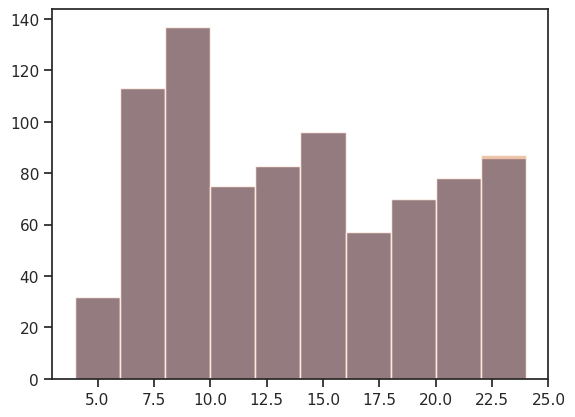

In [11]:
plt.hist(transitions_time_full_model_with_constraints)
plt.hist(transitions_time_our_prediction,alpha=0.5)

In [13]:
set1 = set(np.sort(list_of_proper_indices_our_prediction))
set2 = set(np.sort(list_of_proper_indices_fullmodel))

# Elements in list1 but not in list2
only_in_list1 = set2 - set1
only_in_list1

{45410}

In [ ]:
if LOAD_FILES == False:
    #open all flags for a certain weight set
    list_of_proper_indices_experiment = []
    transitions_time_full_model = []
    transitions_time_experiment = []
    list_of_proper_indices_pv = []
    transitions_time_pv = []
    list_of_proper_indices_sst = []
    transitions_time_sst = []

    transitions_time_experiment_pv_blocked = []
    transitions_time_experiment_sst_blocked = []
    for index in list_of_proper_indices_fullmodel:
        ww_weights = tuple(parameter_sets[index])
        hour_sims = np.arange(48) + 1
        l_all_delta_rE1 = []
        av_threshold_list = []
        name_plot = 'CIR_all_cases'

        flags_list = [(1, 1, 1, 1, 1, 1), (1, 1, 1, 0, 1, 1),(1, 1, 1, 1, 0, 1),(1, 1, 1, 1, 1, 0)]

        for flags in flags_list:
            id, title = determine_name(flags)
        #     name_data = 'Case' + id + '_test_every_h' + '_k' + str(K).replace(".","") + '_td' + str(g_top_down_to_S)
            name_data = 'Case' + id + '_test_every_h' + '_k' + str(K).replace(".","") + '_td' + str(g_top_down_to_S) + "_"
            name_data += '_'.join(str(weight).replace(".","") for weight in ww_weights)

            # Open the file and read
            with open(dir_data + name_data + '.pkl', 'rb') as file:
                l_results = pickle.load(file)
    #         print('Data is read.')

            try:
                [_, l_time_points_phase2, _, l_delta_rE1, av_threshold, _, _] = l_results
            except:
                [_, l_time_points_phase2, _, l_delta_rE1, av_threshold, _, _,_] = l_results
            l_all_delta_rE1.append(l_delta_rE1)
            av_threshold_list.append(av_threshold)

        #handling non-existing one by substituing them with NaN
        for j in range(len(l_all_delta_rE1)):
            if any(l_all_delta_rE1[j]) == 0:
                l_all_delta_rE1[j] = np.full(len(l_all_delta_rE1[j]),np.NaN)
                
        baseline_reactivation = av_threshold_list[0]

        change_in_reactivation = [100 * (np.array(l_all_delta_rE1[i]) - baseline_reactivation) / baseline_reactivation for i in range(len(l_all_delta_rE1))]

    #     print(change_in_reactivation)
        closest_index = [find_switch_index_vectorized(change_in_reactivation[i])  for i in range(len(l_all_delta_rE1))]
        
        for i in range(len(l_all_delta_rE1)):
            if closest_index[i] == None: #because if there isn't a transition, the argmin is gonna return 0
                closest_index[i] = np.NaN
    
        #Kris conditions
        if (closest_index[1] - closest_index[0] >= 0) and (closest_index[0] <=24) and (closest_index[0] >= 4):
            list_of_proper_indices_experiment.append(index)
            transitions_time_full_model.append(closest_index[0])
            transitions_time_experiment.append(closest_index[1])
            transitions_time_experiment_pv_blocked.append(closest_index[2])
            transitions_time_experiment_sst_blocked.append(closest_index[3])
            if (np.isnan(closest_index[2])):
                list_of_proper_indices_pv.append(index)
                transitions_time_pv.append(closest_index[2])
            if (closest_index[3] - closest_index[0] <= 0):
                list_of_proper_indices_sst.append(index)
                transitions_time_sst.append(closest_index[3])

        #save list
        # with open('transitions_time_fullmodel_kris_conditions_' + plastic_str + '.pkl', 'wb') as file:
        #     pickle.dump(transitions_time_full_model, file)

        # with open('transitions_time_exp_kris_conditions_' + plastic_str + '.pkl', 'wb') as file:
        #     pickle.dump(transitions_time_experiment, file)

        # #save list
        # with open('transitions_time_pv_kris_conditions_' + plastic_str + '.pkl', 'wb') as file:
        #     pickle.dump(transitions_time_pv, file)
            
        # #save list
        # with open('transitions_time_sst_kris_conditions_' + plastic_str + '.pkl', 'wb') as file:
        #     pickle.dump(transitions_time_sst, file)
        
        #save list
        with open('list_of_proper_indices_experiment_' + plastic_str + '.pkl', 'wb') as file:
            pickle.dump(list_of_proper_indices_experiment, file)
else:
    # with open('transitions_time_fullmodel_kris_conditions_' + plastic_str + '.pkl', 'rb') as file:
    #     transitions_time_full_model = pickle.load(file)

    # with open('transitions_time_exp_kris_conditions_' + plastic_str + '.pkl', 'rb') as file:
    #     transitions_time_experiment = pickle.load(file)
        
    # with open('transitions_time_pv_kris_conditions_' + plastic_str + '.pkl', 'rb') as file:
    #     transitions_time_pv = pickle.load(file)
        
    # with open('transitions_time_sst_kris_conditions_' + plastic_str + '.pkl', 'rb') as file:
    #     transitions_time_sst = pickle.load(file)
        
    with open('list_of_proper_indices_experiment_' + plastic_str + '.pkl', 'rb') as file:
        list_of_proper_indices_experiment = pickle.load(file)

### Pairplot

In [17]:
ww_weights_pred = [tuple(parameter_sets[i]) for i in list_of_proper_indices_our_prediction]
ww_weights_exp = [tuple(parameter_sets[i]) for i in list_of_proper_indices_experiment]

# Convert lists to sets
set1 = set(ww_weights_pred)
set2 = set(ww_weights_exp)

# Find tuples in list2 not in list1
unique_to_list = set2 - set1

ww_weights_sol = list(set1)
ww_weights_all = list(set2)

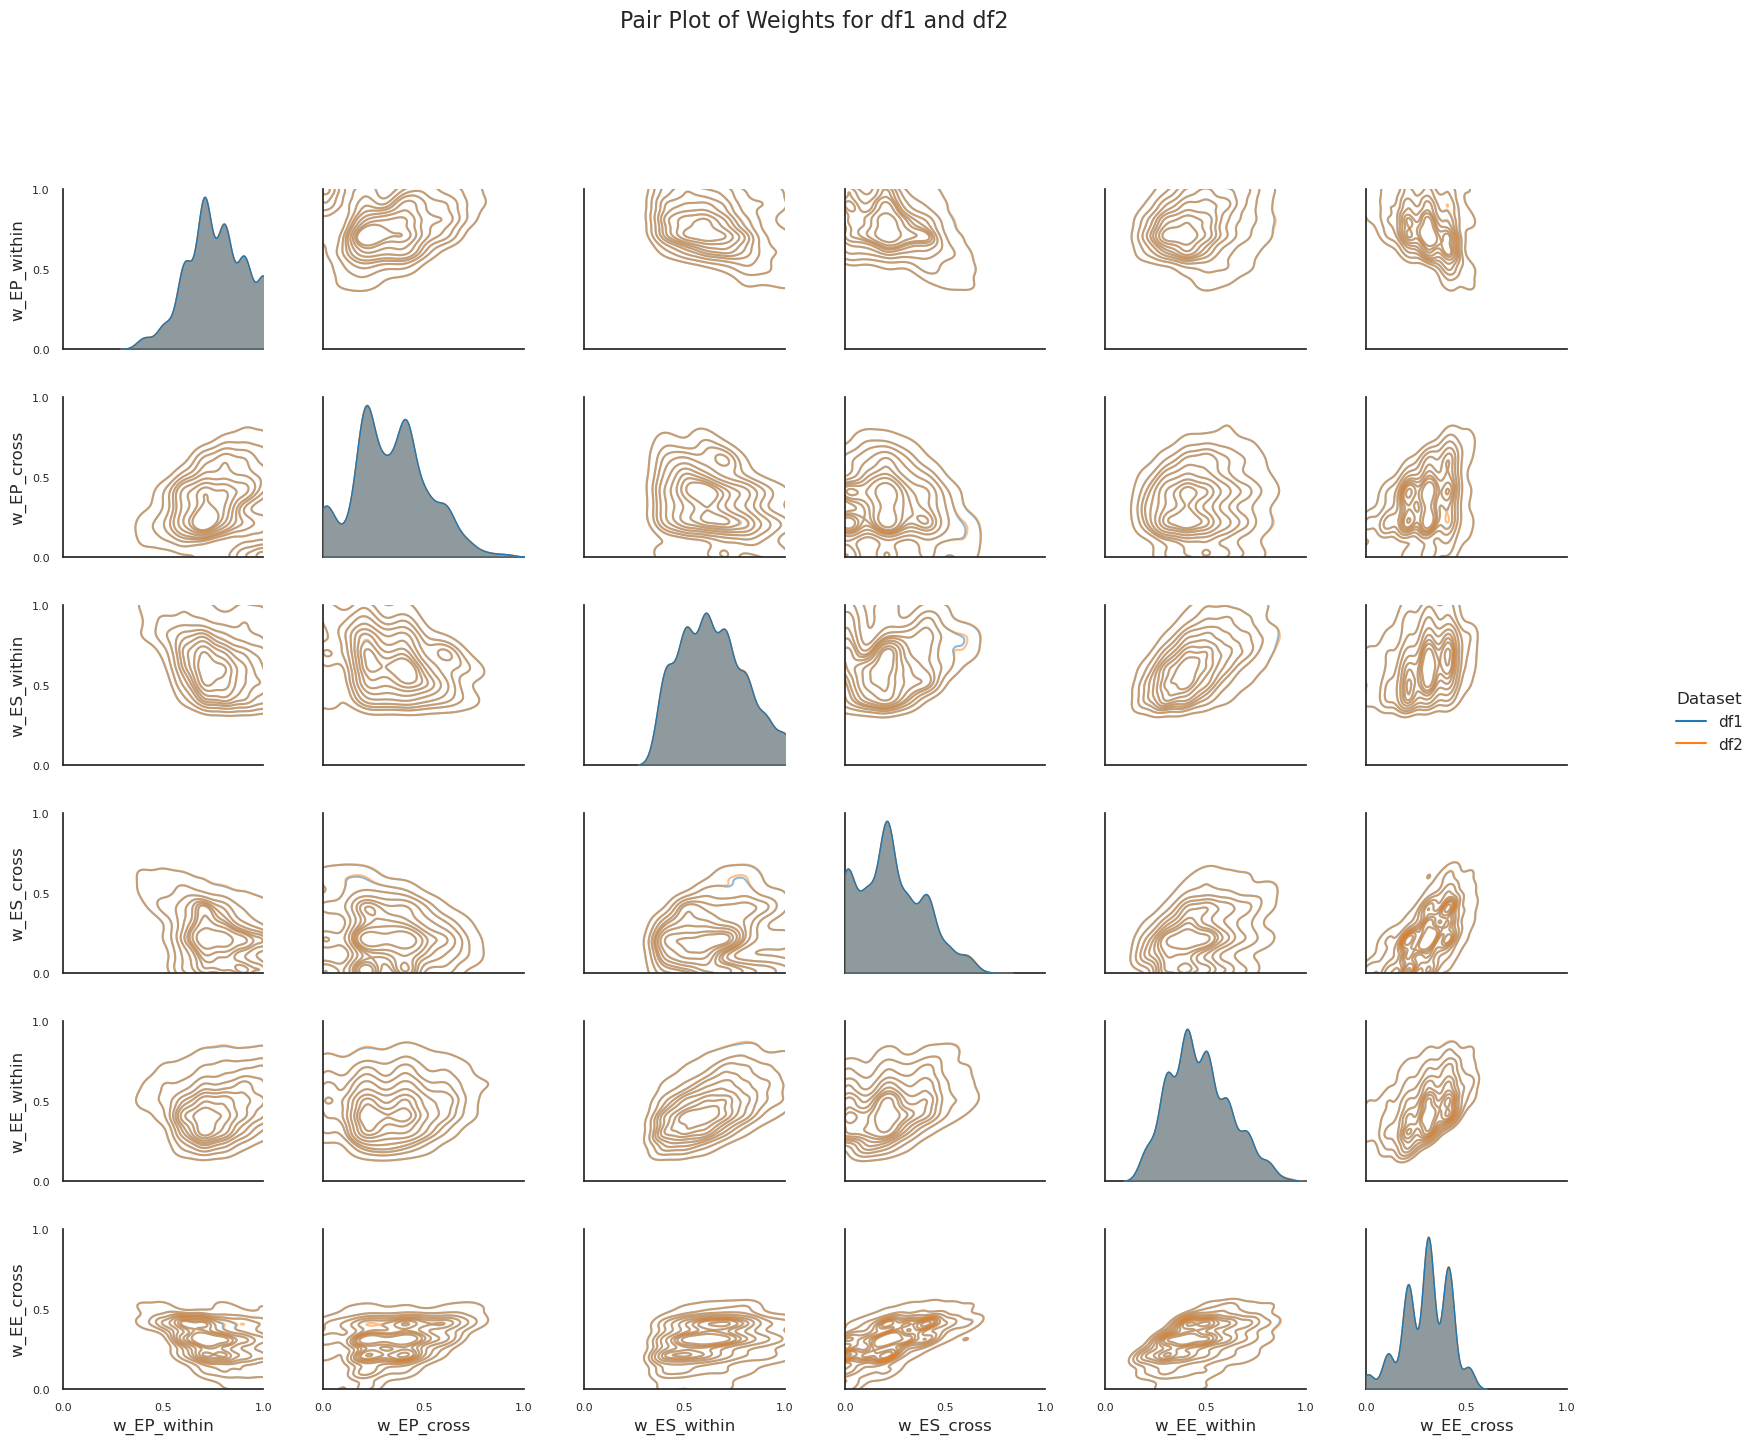

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert lists of tuples to DataFrames
try:
    df1 = pd.DataFrame(ww_weights_sol, columns=["w_EP_within", "w_EP_cross", 
                                               "w_ES_within", "w_ES_cross", 
                                               "w_EE_within", "w_EE_cross"])
    df2 = pd.DataFrame(ww_weights_all, columns=["w_EP_within", "w_EP_cross", 
                                               "w_ES_within", "w_ES_cross", 
                                               "w_EE_within", "w_EE_cross"])
except:
    df1 = pd.DataFrame(ww_weights_sol, columns=["w_PE_within","w_PP_within" ,"w_PS_within", "w_SE_within"])
    df2 = pd.DataFrame(ww_weights_all, columns=["w_PE_within","w_PP_within" ,"w_PS_within", "w_SE_within"])

# Add a 'Dataset' column to distinguish between df1 and df2
df1['Dataset'] = 'df1'
df2['Dataset'] = 'df2'

# Combine the two DataFrames
df_combined = pd.concat([df1, df2], ignore_index=True)

# Define a color palette with distinct colors for each dataset
# palette = sns.color_palette("husl", 2)  # Adjust the palette as needed
# palette = sns.color_palette("Set1", 2)   # Strong reds and blues
# palette = sns.color_palette("Paired", 2) # Good contrast pairs
# palette = sns.color_palette("Dark2", 2)  # Saturated, darker tones
palette = ["#1f77b4", "#ff7f0e"]  # blue vs orange (matplotlib defaults)

# Set the Seaborn style
sns.set(style="white")

# Create the pair plot with KDE and hue to differentiate datasets
pairplot = sns.pairplot(
    df_combined,
    hue='Dataset',
    kind='kde',
    diag_kind='kde',
    diag_kws={'alpha': 0.5, 'fill': True},
    plot_kws={'alpha': 0.5},
    palette=palette,
    height=2.5,
    aspect=1.2
)

# Adjust plot spacing and tick marks
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.3, wspace=0.3)

# Set the same limits and ticks for all axes
for i, col in enumerate(df1.columns[:-1]):  # Exclude the 'Dataset' column
    for j, row in enumerate(df1.columns[:-1]):
        if i >= j:
            ax = pairplot.axes[i, j]
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_xticks([0.0, 0.5, 1.0])
            ax.set_yticks([0.0, 0.5, 1.0])
            ax.tick_params(axis='both', labelsize=8)
            ax.get_yaxis().set_visible(True)

# Adjust overall aesthetics
pairplot.fig.suptitle('Pair Plot of Weights for df1 and df2', fontsize=16, y=1.02)  # Add a title

# Optional: Save the figure
# plt.savefig("paper_fig/data/figures/supp/" + "pairplot_comparison_" + plastic_str + ".pdf")
# plt.savefig("paper_fig/data/figures/supp/" + "pairplot_comparison_"  + plastic_str + ".png", dpi=300)

plt.show()


In [20]:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # ---- Inputs: ww_weights_sol, ww_weights_all must be lists/arrays of equal-length tuples ----
# df1_raw = pd.DataFrame(ww_weights_sol)
# df2_raw = pd.DataFrame(ww_weights_all)

# # 1) Harmonize columns: keep common numeric columns, rename if you like
# num1 = df1_raw.select_dtypes(include=[np.number])
# num2 = df2_raw.select_dtypes(include=[np.number])
# common_cols = [c for c in num1.columns if c in num2.columns]
# if len(common_cols) < 2:
#     raise ValueError("Need at least two common numeric columns to make a pair plot.")

# df1 = num1[common_cols].copy()
# df2 = num2[common_cols].copy()
# df1["Dataset"] = "df1"
# df2["Dataset"] = "df2"
# df = pd.concat([df1, df2], ignore_index=True)

# # 2) Consistent per-dimension limits from pooled data (quantile-based; clamp to [0,1] if appropriate)
# #    Set clamp01=False to disable clamping.
# clamp01 = True
# q_lo, q_hi = 0.001, 0.999  # robust against outliers; tighten if needed
# lims = {}
# for c in common_cols:
#     lo = df[c].quantile(q_lo)
#     hi = df[c].quantile(q_hi)
#     if clamp01:
#         lo, hi = max(0.0, lo), min(1.0, hi)
#     if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
#         lo, hi = df[c].min(), df[c].max()
#     pad = 0.02 * (hi - lo if hi > lo else 1.0)
#     lims[c] = (lo - pad, hi + pad)

# # 3) Palette and styles (colorblind-safe + linestyle for redundancy)
# # palette = sns.color_palette("colorblind", 2)           # e.g., blue & orange (colorblind-friendly)
# palette = ["#1f77b4", "#ff7f0e"]  # blue vs orange (matplotlib defaults)
# line_styles = {"df1": "solid", "df2": (0, (5, 2))}    # dashed pattern for df2

# sns.set(context="paper", style="white", rc={
#     "axes.spines.right": False, "axes.spines.top": False,
#     "legend.frameon": False
# })

# # 4) PairGrid with corner=True; unfilled contours off-diagonal, filled KDE on diagonal
# g = sns.PairGrid(
#     df,
#     hue="Dataset",
#     vars=common_cols,
#     corner=True,      # lower triangle only
#     height=2.4,
#     despine=False
# )

# # # Replace this
# # line_styles = {"df1": "solid", "df2": (0, (5, 2))}

# # With this
# line_styles = {"df1": "solid", "df2": "solid"}

# def offdiag_kde(x, y, color, label, **kwargs):
#     ls = line_styles.get(label, "solid")
#     sns.kdeplot(
#         x=x, y=y, color=color,
#         fill=False, levels=14, thresh=0.05,
#         linewidths=0.5, linestyles=ls, **kwargs
#     )


# # Diagonal: filled KDEs with slight transparency
# def diag_kde(x, color, label, **kwargs):
#     sns.kdeplot(
#         x=x, color=color,
#         fill=True, alpha=0.35, linewidth=1.0, **kwargs
#     )

# g.map_lower(offdiag_kde)
# g.map_diag(diag_kde)

# # 5) Apply consistent limits and tidy ticks
# for i, row_var in enumerate(common_cols):
#     for j, col_var in enumerate(common_cols):
#         ax = g.axes[i, j] if i > 0 and j < i else (g.diag_axes[j] if i == j else None)
#         if ax is None:
#             continue
#         if i == j:
#             ax.set_xlim(0,1)
#             ax.set_yticks([])  # cleaner diagonal
#         else:
#             ax.set_xlim(0,1)
#             ax.set_ylim(0,1)
#         ax.tick_params(labelsize=8)

# # 6) Legend and title
# handles, labels = g.axes[-1, 0].get_legend_handles_labels() if hasattr(g.axes[-1, 0], "get_legend_handles_labels") else g.fig.axes[0].get_legend_handles_labels()
# g.fig.legend(handles, labels, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.02))
# g.fig.suptitle("Pairwise comparison of weight distributions", y=1.08, fontsize=14)

# plt.tight_layout()
# # plt.savefig("paper_fig/data/figures/supp/" + "pairplot_comparison_new_colors_" + plastic_str + ".pdf")
# # plt.savefig("paper_fig/data/figures/supp/" + "pairplot_comparison_new_colors_"  + plastic_str + ".png", dpi=300)
# plt.show()


# Plotting dependence on baseline activity (Fig S6)

Load the list of parameters as before

In [ ]:
plastic = False #it opens the parameter file for the plastic operations if set True
if plastic == True:
    plastic_str = 'plastic'
    indices_tot_plastic = []
else:
    plastic_str = 'static'
    indices_tot_static = []

#You can open all the paramters combination from the original file and save them in a list of lists
file_path = 'param_total_' + plastic_str + '.txt'
  
# file_path = '/home/ge74coy/mnt/naspersonal/Code/synaptic_scaling/param1.txt'

with open(file_path, 'r') as file:
    # Read lines from the file
    lines = file.readlines()

# Process each line and create a list of parameter sets
parameter_sets = []
for line in lines:
    # Split the line into individual floats using commas as separators
    parameters = [float(value) for value in line.strip().split(',')]
    parameter_sets.append(parameters)
    
ww_weights = tuple(parameter_sets[0])

with open('list_of_proper_indices_our_prediction_' + plastic_str + '.pkl', 'rb') as file:
    list_of_proper_indices_our_prediction = pickle.load(file)

In [29]:
if LOAD_FILES == False:
    # SAVING ALL THE SWITCH INDICES IN FULL NETWORK 
    indices_tot_plastic = []
    indices_tot_static = []
    for index in list_of_proper_indices_our_prediction:
        ww_weights = tuple(parameter_sets[index])
        
        dir_data = '/home/ge74coy/mnt/nasgroup/labmembers/fabioveneto/synaptic_scaling/data/'
        # dir_data = '/home/ge74coy/mnt/nasgroup/labmembers/fabioveneto/synaptic_scaling/strong_connection/data/'
        K = 0.25
        g_top_down_to_S = 0
        flags = (1, 1, 1, 1, 1, 1)
        id, title = determine_name(flags)
        name_data = 'Case' + id + '_test_every_h' + '_k' + str(K).replace(".","") + '_td' + str(g_top_down_to_S) + "_"
        name_data += '_'.join(str(weight).replace(".","") for weight in ww_weights)

        try:
            with open(dir_data + name_data + '.pkl', 'rb') as file:
                l_results = pickle.load(file)
            # Extracting data from the loaded results
    #         [_, l_time_points_phase2, _, l_delta_rE1, av_threshold, _, _] = l_results
            try:
                [r_phase1, _, _, _, _, _, _, _] = l_results
            except:
                [r_phase1, _, _, _, _, _, _] = l_results
            if plastic == True:
                indices_tot_plastic.append(r_phase1[0][0])
            elif plastic == False:
                indices_tot_static.append(r_phase1[0][0])
        
        except FileNotFoundError:
            print(f"File not found: {dir_data + name_data + '.pkl'}. Skipping.")
            continue

        except Exception as e:
            print(f"An error occurred: {e}. Skipping.")
            continue


    data = {
        "plastic": indices_tot_plastic,
        "static":  indices_tot_static
    }

    with open("indices_r_baseline.pkl", "wb") as f:
        pickle.dump(data, f)
else:
    with open("indices_r_baseline.pkl", "rb") as f:
        data = pickle.load(f)

    indices_tot_plastic = data["plastic"]
    indices_tot_static  = data["static"]


In [ ]:
indices_tot = indices_tot_plastic + indices_tot_static

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


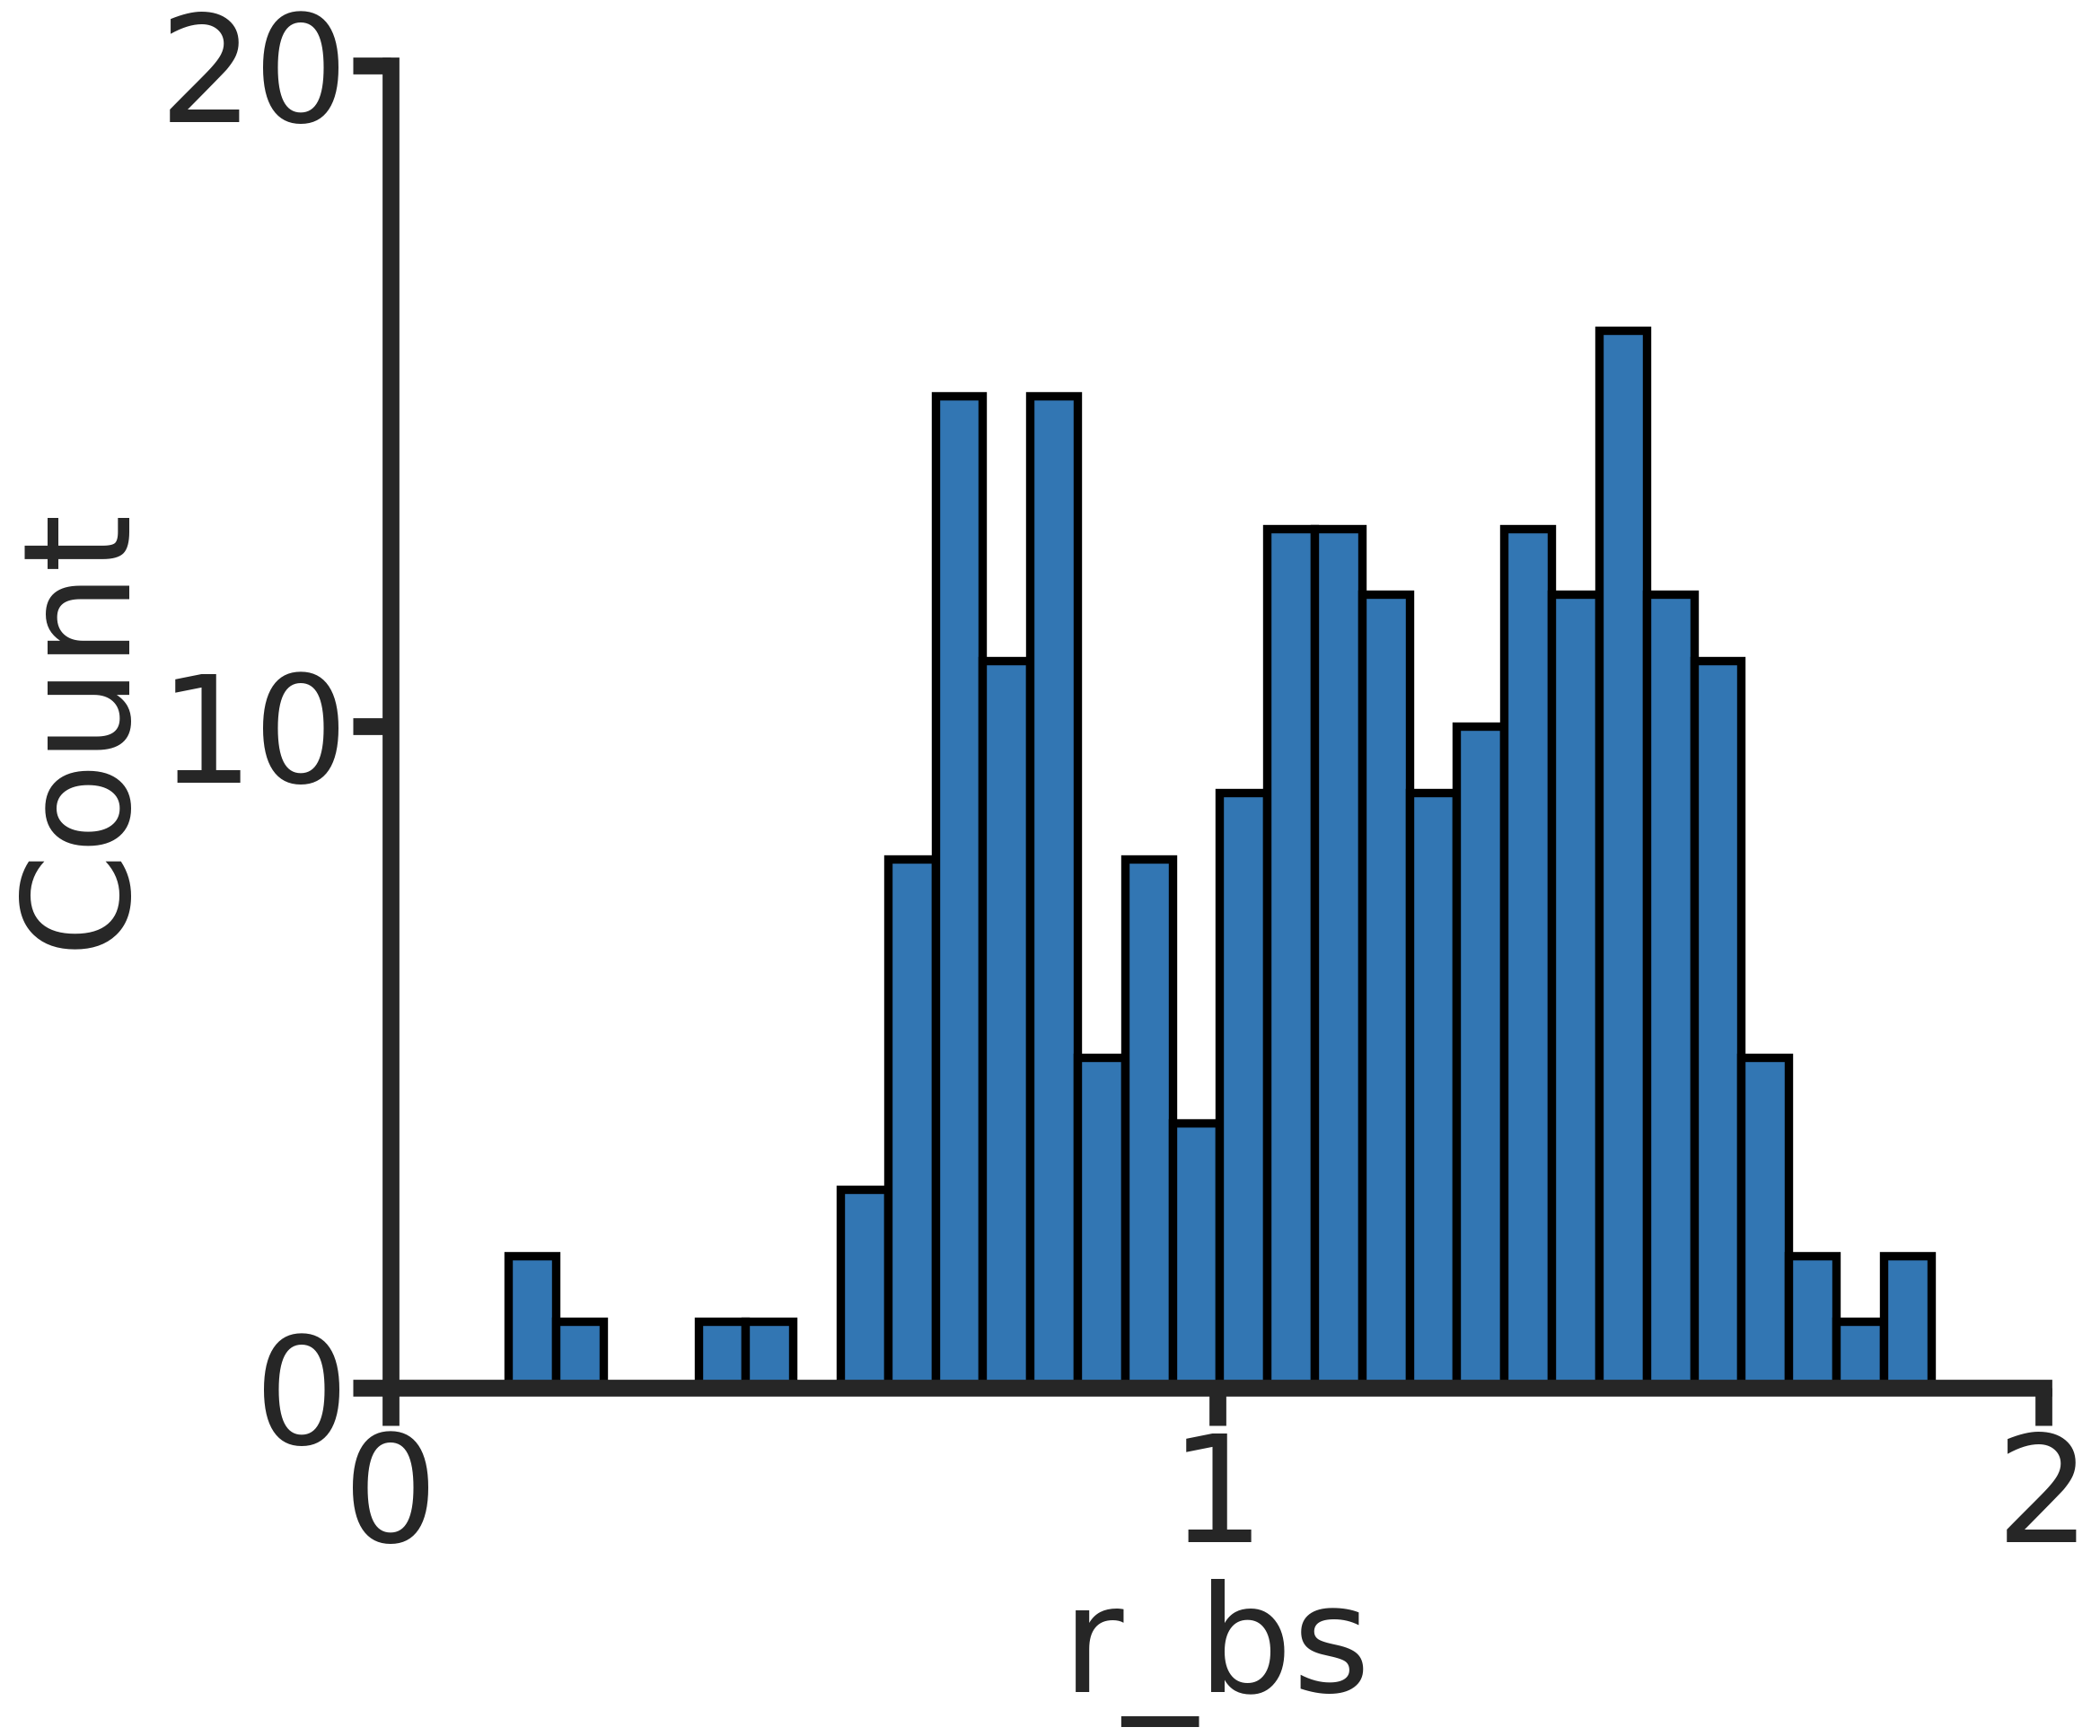

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Plotting configuration ---
ratio = 1.5
figure_len, figure_width = 13 * ratio, 15.7 * ratio
font_size_1, font_size_2 = 80 * ratio, 65 * ratio
font_size_label = 80 * ratio
legend_size = 50 * ratio
line_width, tick_len = 9 * ratio, 20 * ratio
hfont = {'fontname': 'Arial'}
sns.set(style='ticks')

color_list = ['#3276b3', '#91bce0',
              '#C10000', '#EFABAB',
              '#007100', '#87CB87',
              '#80808026']

# --- Histogram plotting ---
plt.figure(figsize=(figure_width, figure_len))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(line_width)

plt.tick_params(width=line_width, length=tick_len)

# Histogram itself
n_bins = 30
counts, bins, patches = ax.hist(
    indices_tot, bins=n_bins, color=color_list[0],
    edgecolor='black', linewidth=line_width/2
)

# Axis formatting
plt.xticks([0.0,1.0,2.0],fontsize=font_size_1, **hfont)
plt.yticks([0,10,20],fontsize=font_size_1, **hfont)
plt.xlabel('r_bs', fontsize=font_size_label, **hfont)
plt.ylabel('Count', fontsize=font_size_label, **hfont)

plt.tight_layout()
# plt.savefig("paper_fig/data/figures/supp/" + "histogram_baseline_activity" + ".pdf")
plt.show()
